In [1]:
from typing import (Any, Callable, Dict, Generic, Iterable, List, Mapping,
                    NewType, Sequence, Tuple, TypeVar, Union)

import os, re, sys, traceback

import datetime, math

from operator import itemgetter

import csv

import numpy as np  # type: ignore
import pandas as pd  # type: ignore

import fiona  # type: ignore
from fiona.crs import from_epsg # type: ignore
import geopandas as gpd  # type: ignore
import shapely # type: ignore
from shapely.geometry import Point

import matplotlib.pyplot as plt  # type: ignore
import seaborn as sns  # type: ignore


%matplotlib inline

## data preparations and aggregation for SOC sample datsets

- preparing the inputs for the RandomForest machine learning step
- joining and standardizing columns and calculate SC from SOM where necessary

In [2]:
import locale
from locale import atof

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

locale.setlocale(locale.LC_NUMERIC, 'Estonian')

soc_dir = 'data/soc_rf_model/'

'Estonian_Estonia.1257'

In [3]:
a1_c = "alar_emu_soc_bd_coords.csv" # punkt_id;longitude;latitude
a1_v = "alar_emu_soc_bd_values.csv" # a1_geo_shp punkt_id;Dm_15;Dm_25;mullatüüp;Corg, %;lõimis;kores_a;
a1_geo_shp = "alar_emu_soc_bd.shp"

a2_open = "estonian_alvars_open_areas.csv" # a2_open site;region;X;Y;soil_depth_average;Org %;pH (KCl);P (mg/kg) (AL);K (mg/kg)(AL);Ca (mg/kg);Mg (mg/kg);N %;comment
a2_open_geo_shp = "estonian_alvars_open_areas.shp"

a2_over = "estonian_alvars_overgrown_areas_soil_data.csv" # a2_over site;region;LÜHEND;subsite;X;Y;soil_depth_average;sd_soil_depth;cv_soil_depth;Org %;pH (KCl);P (mg/kg) (AL);K (mg/kg)(AL);Ca (mg/kg);Mg (mg/kg)
a2_over_geo_shp = "estonian_alvars_overgrown_areas_soil_data.shp"

a3_rmk = "rmk_soil_data.csv" # a3_rmk nr;kood;xcoord;ycoord;pH_KCl;N;P;K;Ca;Mg;SOM %
a3_rmk_geo_shp = "rmk_soil_data.shp"

a4_kik = "estonian_alvars_soil_kik_dataset.csv" # Code;X;Y;subsite;soil_pH;soil_P;soil_K;soil_Mg;soil_Ca;soil_OA;soil_depth_average
a4_kik_geo_shp = "estonian_alvars_soil_kik_dataset.shp"

a5_ee = "estonian_alvars_soil_sample_single_dataset.csv" # a5_ee Site;X;Y;Org %;N %;pH (KCl);P (mg/kg) (AL);K (mg/kg)(AL);Ca (mg/kg);Mg (mg/kg);S_depth_cm
a5_ee_geo_shp = "estonian_alvars_soil_sample_single_dataset.shp"

a6_bogs = "ain_bogs_soil_data.csv" # a2_open Site_ID;BogPeat;TranPeat;FenPeat;Total_Peat;Surface_height;N_X_m;E_Y_m;Soil_pHKCl;Soil_DryMat_%;S_OM%;S_TC%;S_Ash%;AveWL;OM_Bulk_density;Decomposition_rate;
a6_bogs_geo_shp = "ain_bogs_soil_data.shp"

soc_dir = "soc_rf"

df_a1_c =    pd.read_csv(os.path.join(soc_dir, a1_c), encoding='latin1', sep=';', quotechar='"')
display(df_a1_c.sample(3))

df_a1_v =    pd.read_csv(os.path.join(soc_dir, a1_v), encoding='latin1', sep=';', quotechar='"')
display(df_a1_v.sample(3))

df_a1 = pd.merge(df_a1_v, df_a1_c, left_on="punkt_id", right_on="punkt_id")
display(df_a1.sample(3))

df_a2_open = pd.read_csv(os.path.join(soc_dir, a2_open), encoding='latin1', sep=';', quotechar='"')
display(df_a2_open.sample(3))

df_a2_over = pd.read_csv(os.path.join(soc_dir, a2_over), encoding='latin1', sep=';', quotechar='"')
display(df_a2_over.sample(3))

df_a3_rmk =  pd.read_csv(os.path.join(soc_dir, a3_rmk), encoding='latin1', sep=';', quotechar='"')
display(df_a3_rmk.sample(3))

df_a4_kik =  pd.read_csv(os.path.join(soc_dir, a4_kik), encoding='latin1', sep=';', quotechar='"')
display(df_a4_kik.sample(3))

df_a5_ee =   pd.read_csv(os.path.join(soc_dir, a5_ee), encoding='latin1', sep=';', quotechar='"')
display(df_a5_ee.sample(3))

df_a6_bogs = pd.read_csv(os.path.join(soc_dir, a6_bogs), encoding='latin1', sep=';', quotechar='"')
display(df_a6_bogs.sample(3))

,punkt_id,X,Y
2699,VilbuB7,"25,7623","59,1731"
163,BachmaniB6,"25,9636","59,1699"
108,AruA10,"25,7575","59,2051"


,punkt_id,bd_15,bd_25,siffer,SOC,loimis,kores,N,pH_KCl,P,K,Ca,Mg
3997,MatuD7,NaN,NaN,LP,"0,98",sl,NaN,"0,12","5,12",11,12,30.0,"2,5"
983,HünoneniD6,"1,49","1,69",KIg,"1,15",ls1,NaN,"0,14","6,61",9,4,220.0,17
2112,KogeriD8,NaN,NaN,G,NaN,NaN,NaN,"0,24",7,13,17,380.0,40


,punkt_id,bd_15,bd_25,siffer,SOC,loimis,kores,N,pH_KCl,P,K,Ca,Mg,X,Y
6857,TuuleveskiA4,"1,37","1,61",K,"2,29",NaN,6.0,"0,22","7,13",24,15,870.0,"9,5","24,7868","59,3088"
5038,PuuriC4,NaN,"1,75",LP,"0,82",NaN,NaN,"0,08","6,8",17,8,120.0,"5,5","27,0353","58,0476"
7393,VahtramäeD4,"1,41","1,54",NaN,NaN,NaN,10.0,"0,21","7,25",30,21,2100.0,73,"23,5346","58,8672"


,site,region,X,Y,soil_depth_average,SOM,pH_KCl,P,K,Ca,Mg,N,comment
111,LOE1-A,Muhu,"23,3141","58,65","13,3","9,918526077","6,94","50,98163265","177,9547361","2290,447176","932,2841224",NaN,data from 2016
76,Vilsan-b,Saaremaa,"21,8292","58,3833","3,33","16,85","7,02","13,55","138,52",3621,"927,82","1,06",data from 2008-2014
22,Korkvere,Saaremaa,"23,242168","58,485333","14,69","7,99","7,00","18,29","224,53",2748,"313,58","0,38",data from 2008-2014


,site,region,LÜHEND,subsite,X,Y,soil_depth_average,sd_soil_depth,cv_soil_depth,SOM,pH_KCl,P,K,Ca,Mg
37,Mõnnuste,Saaremaa,MON-C,METS,"22,3076","58,3194","6,25","4,131518419","0,661042947","10,92274262","6,82","0,599822785","177,8993714","3443,350952","173,5039114"
66,Võiküla 2,Muhu,VOI2-C,METS,"23,3067","58,5504","13,3","3,267686916","0,245690746","9,251934932","7,02","8,465753425","110,5105479","2883,648288","731,8047945"
27,Kurese,Lääne-Eesti,KUR-C,METS,"24,1296","58,6468","11,25","2,40658818","0,213918949","9,480987195","6,9","14,89268897","151,0330533","2667,185561","758,7557621"


,nr,kood,X,Y,pH_KCl,N,P,K,Ca,Mg,SOM
81,82,082Munamae,"27,05778","57,71301","4,3","0,172712478","4,507388639","55,51404953","574,9024637","77,9394197","4,36178586"
69,70,070Lohmuskund,"26,60557","57,99192","4,03","0,239008484","6,919887233","87,21202674","369,6589596","69,87669754","5,3390294"
12,13,013Rookse,"27,02859","58,25366","3,87","0,376819695","51,11876986","167,189832","566,5345731","63,03092464","10,58323829"


,Code,X,Y,subsite,pH_KCl,P,K,Mg,Ca,SOM,soil_depth_average
122,VAN-K,"22,6743","58,2432",KONTROLL,"6,81","25,13981403","186,6276872","585,3759298","3735,944245","17,18538462",13
76,NEE-C,"21,924","58,4985",METS,"7,03","18,8582307","77,49111709","476,8321075","3107,538259","9,79593235","17,65"
136,VOR-K,"22,7441","58,3893",KONTROLL,"7,05","0,246980746","166,0338353","192,1613109","3228,605577","7,362093404","8,5"


,Site,X,Y,SOM,N,pH_KCl,P,K,Ca,Mg,soil_depth_average
77,Ura,"24,19583333","58,60611111","19,51","1,069","6,91","10,6","286,27",3880.0,"992,4","6,75"
68,Suuremoi,"22,675","58,24166667","16,84","0,926","6,51","17,07","286,51",5375.0,"260,17","9,10"
72,Tarva,"24,010713","58,623443","9,33",NaN,"7,11","9,92",NaN,NaN,NaN,"14,43"


,Site_ID,BogPeat,TranPeat,FenPeat,Total_Peat,Surface_height,N_X_m,E_Y_m,pH_KCl,Soil_DryMat_%,S_OM%,S_TC%,S_Ash%,AveWL,OM_Bulk_density,Decomposition_rate
134,Kassi6,"0,4",0,"1,92","2,32","39,3646","6557396,089","708356,399","3,36","8,26","81,01",42,"5,77","-5,752380952","0,066057403","0,3365"
154,Laiuse_B,NaN,NaN,NaN,NaN,NaN,"6519433,8","646045,9","2,5","15,29968454","85,94516255","53,6","1,856788308",NaN,NaN,NaN
42,Koo3,"1,35","0,2","2,75","4,3","74,2104","6538655,453","594922,924","2,5","11,3082955","80,05734177",51,"3,443209806","-19,24285714","0,086245321","0,41175"


In [4]:
for df in [ df_a1, df_a2_open, df_a2_over, df_a3_rmk, df_a4_kik, df_a5_ee]:
    # display(df.dtypes['X'])
    # display(df.dtypes['Y'])
    df['X'] = df['X'].apply(atof).astype(float)
    df['Y'] = df['Y'].apply(atof).astype(float)
    df['geometry'] = df.apply(lambda x: Point(x['X'], x['Y']), axis=1)
    df['wkt'] = df['geometry'].apply(lambda x: str(x.wkt))
    # display(df.dtypes['X'])
    # display(df.dtypes['Y'])
    # display(df.sample(3))

for df in [ df_a1, df_a2_open, df_a2_over, df_a3_rmk, df_a4_kik, df_a5_ee]:
    
    for field in ['soil_depth_average','sd_soil_depth','cv_soil_depth', 'SOC', 'SOM','pH_KCl','N','P','K','Ca','Mg','bd_15','bd_25','kores']:
        if field in df.columns:
            # display(df.dtypes[field])
            if is_string_dtype(df[field]):
                df[field] = df[field].astype(str).apply(atof).astype(float)
                # display(df.dtypes[field])
    
    if 'SOM' in df.columns:
        df['SOC'] = df.apply(lambda x: x['SOM'] / 1.724, axis=1)
        # display(df.dtypes['SOM'])
    display(df.sample(3))

##############
# ain extra below

,punkt_id,bd_15,bd_25,siffer,SOC,loimis,kores,N,pH_KCl,P,K,Ca,Mg,X,Y,geometry,wkt
4265,NaadimetsaB1,1.37,1.42,LPg,1.04,NaN,NaN,0.08,5.29,11.5,11.0,20.0,2.5,26.9525,58.0216,POINT (26.9525 58.0216),POINT (26.9525 58.0216)
6288,StroomiD2,NaN,NaN,K,2.16,NaN,6.0,0.19,7.08,9.0,24.0,790.0,135.0,26.5000,59.2010,POINT (26.5 59.201),POINT (26.5 59.201)
4004,MetsakikkaA1,NaN,1.44,LP,1.08,sl,NaN,0.09,5.82,11.5,13.0,55.0,4.8,26.5625,58.3620,POINT (26.5625 58.362),POINT (26.5625 58.362)


,site,region,X,Y,soil_depth_average,SOM,pH_KCl,P,K,Ca,Mg,N,comment,geometry,wkt,SOC
64,Tolinomme,Põhja-Eesti,24.389865,59.379824,8.23,26.790000,6.57,23.100000,NaN,NaN,NaN,NaN,data from 2008-2014,POINT (24.389865 59.379824),POINT (24.389865 59.379824),15.539443
87,ASV1-K,Saaremaa,23.061200,58.445300,7.35,7.261919,7.17,15.779043,131.363187,1745.329713,677.55863,NaN,data from 2016,POINT (23.0612 58.4453),POINT (23.0612 58.4453),4.212250
29,Marinu,Põhja-Eesti,26.420262,59.465455,12.95,25.370000,6.59,254.930000,NaN,NaN,NaN,NaN,data from 2008-2014,POINT (26.420262 59.465455),POINT (26.420262 59.465455),14.715777


,site,region,LÜHEND,subsite,X,Y,soil_depth_average,sd_soil_depth,cv_soil_depth,SOM,pH_KCl,P,K,Ca,Mg,geometry,wkt,SOC
49,Paope,Hiiumaa,PAO-C,METS,22.4362,58.9414,20.333333,3.500000,0.172131,11.550155,6.69,17.507420,38.154009,3888.677442,50.583865,POINT (22.4362 58.9414),POINT (22.4362 58.9414),6.699626
0,Aruküla,Hiiumaa,ARU-B,KADASTIK,22.9836,58.8632,15.200000,5.349974,0.351972,6.203729,6.86,3.496522,43.815285,2959.707394,43.777677,POINT (22.9836 58.8632),POINT (22.9836 58.8632),3.598451
54,Tammese,Saaremaa,TAM-B,KADASTIK,21.9949,58.4219,8.800000,3.966527,0.450742,11.132581,6.86,1.919404,67.311449,3814.505636,71.533932,POINT (21.9949 58.4219),POINT (21.9949 58.4219),6.457414


,nr,kood,X,Y,pH_KCl,N,P,K,Ca,Mg,SOM,geometry,wkt,SOC
41,42,042Abjasoo,26.39829,57.65318,2.83,0.145909,6.993228,45.875775,111.284685,18.655344,7.857953,POINT (26.39829 57.65318),POINT (26.39829 57.65318),4.557977
50,51,051Kadaja,26.05123,57.99957,3.08,0.090512,12.726336,58.668812,115.979545,21.552342,3.477900,POINT (26.05123 57.99957),POINT (26.05123 57.99957),2.017343
94,95,095Hurda,26.81414,57.71000,2.46,0.269369,8.974466,109.835455,167.052254,46.734378,13.825254,POINT (26.81414 57.71),POINT (26.81414 57.71),8.019289


,Code,X,Y,subsite,pH_KCl,P,K,Mg,Ca,SOM,soil_depth_average,geometry,wkt,SOC
116,UUG-K,23.2360,58.6712,KONTROLL,6.88,30.054797,145.274472,991.600756,3080.381160,14.449388,5.40,POINT (23.236 58.6712),POINT (23.236 58.6712),8.381316
110,TYR-B-UUS,21.9954,57.9767,KADASTIK,6.85,131.688463,237.981752,447.887711,5210.867134,24.501373,9.50,POINT (21.9954 57.9767),POINT (21.9954 57.9767),14.211933
54,KUR-C,24.1296,58.6468,METS,6.90,14.892689,151.033053,758.755762,2667.185561,9.480987,11.25,POINT (24.1296 58.6468),POINT (24.1296 58.6468),5.499413


,Site,X,Y,SOM,N,pH_KCl,P,K,Ca,Mg,soil_depth_average,geometry,wkt,SOC
46,Osmuss-n,23.375000,59.298611,41.76,1.814,6.78,54.56,504.77,10770.0,129.57,4.18,POINT (23.375 59.29861111),POINT (23.375 59.29861111),24.222738
48,Paadla,22.305900,58.280700,8.26,0.371,6.04,2.12,102.20,2024.0,231.91,14.22,POINT (22.3059 58.2807),POINT (22.3059 58.2807),4.791183
37,Muraste,24.440806,59.455541,19.74,NaN,5.77,111.52,NaN,NaN,NaN,22.60,POINT (24.440806 59.455541),POINT (24.440806 59.455541),11.450116


In [5]:
# N_X_m;E_Y_m
# display(df.dtypes['X'])
# display(df.dtypes['Y'])
df_a6_bogs['N_X_m'] = df_a6_bogs['N_X_m'].apply(atof).astype(float)
df_a6_bogs['E_Y_m'] = df_a6_bogs['E_Y_m'].apply(atof).astype(float)
df_a6_bogs['geometry'] = df_a6_bogs.apply(lambda x: Point(x['E_Y_m'], x['N_X_m']), axis=1)
df_a6_bogs['wkt'] = df_a6_bogs['geometry'].apply(lambda x: str(x.wkt))
# display(df.dtypes['X'])
# display(df.dtypes['Y'])
# display(df.sample(3))


    
for field in ['pH_KCl','Soil_DryMat_%','S_OM%','S_TC%','S_Ash%','OM_Bulk_density']:
    if field in df_a6_bogs.columns:
        # display(df.dtypes[field])
        if is_string_dtype(df_a6_bogs[field]):
            df_a6_bogs[field] = df_a6_bogs[field].astype(str).apply(atof).astype(float)
            # display(df.dtypes[field])

if 'S_TC%' in df_a6_bogs.columns:
    df_a6_bogs['SOC'] = df_a6_bogs.apply(lambda x: x['S_TC%'] / 1.724, axis=1)
    # display(df.dtypes['SOM'])
display(df_a6_bogs.sample(3))

,Site_ID,BogPeat,TranPeat,FenPeat,Total_Peat,Surface_height,N_X_m,E_Y_m,pH_KCl,Soil_DryMat_%,S_OM%,S_TC%,S_Ash%,AveWL,OM_Bulk_density,Decomposition_rate,geometry,wkt,SOC
171,Sipe_alam,NaN,NaN,NaN,NaN,NaN,6454932.200,664010.300,5.02,NaN,57.510000,32.0,NaN,NaN,NaN,NaN,POINT (664010.3 6454932.2),POINT (664010.3 6454932.2),18.561485
94,Umb3,"2,84","0,11","2,61","5,56","43,1004",6494683.797,626989.596,2.47,11.799410,83.522255,47.0,2.529296,"-33,05625",0.082041,"0,328",POINT (626989.596 6494683.797),POINT (626989.596 6494683.797),27.262181
151,Kõima_C_turbaauk,NaN,NaN,NaN,NaN,NaN,6497211.600,513688.100,2.47,5.895786,84.728537,51.5,2.019635,NaN,NaN,NaN,POINT (513688.1 6497211.6),POINT (513688.1 6497211.6),29.872390


In [6]:
df_a1_geo = gpd.GeoDataFrame(df_a1, crs=from_epsg(4326), geometry="geometry")
# a1_geo_shp punkt_id;Dm_15;Dm_25;siffer;Corg, %;loimis;kores;
df_a1_geo['site_id'] = df_a1_geo['punkt_id']
df_a1_geo['origin'] = a1_geo_shp
df_a1_geo['comment'] = df_a1_geo.apply(lambda x: "{} {} arable soils".format(x['siffer'], x['loimis']), axis=1)
df_a1_geo = df_a1_geo[['SOC','pH_KCl','P','K','Ca','Mg','site_id', 'comment', 'origin' , 'N','kores', 'bd_15','bd_25','X','Y','geometry','wkt']]
display(df_a1_geo.sample(3))

df_a2_open_geo = gpd.GeoDataFrame(df_a2_open, crs=from_epsg(4326), geometry="geometry")
# a2_open site;region;X;Y;soil_depth_average;Org %;pH (KCl);P (mg/kg) (AL);K (mg/kg)(AL);Ca (mg/kg);Mg (mg/kg);N %;comment
df_a2_open_geo['site_id'] = df_a2_open_geo['site']
df_a2_open_geo['origin'] = a2_open_geo_shp
df_a2_open_geo['comment'] = df_a2_open_geo.apply(lambda x: "{} {} open alvars".format(x['comment'], x['region']), axis=1)
df_a2_open_geo = df_a2_open_geo[['SOC','pH_KCl','P','K','Ca','Mg','site_id', 'comment','origin' , 'N','soil_depth_average' ,'X','Y','geometry','wkt']]
display(df_a2_open_geo.sample(3))

df_a2_over_geo = gpd.GeoDataFrame(df_a2_over, crs=from_epsg(4326), geometry="geometry")
# a2_over site;region;LÜHEND;subsite;X;Y;soil_depth_average;sd_soil_depth;cv_soil_depth;Org %;pH (KCl);P (mg/kg) (AL);K (mg/kg)(AL);Ca (mg/kg);Mg (mg/kg)
df_a2_over_geo['site_id'] = df_a2_over_geo['site']
df_a2_over_geo['origin'] = a2_over_geo_shp
df_a2_over_geo['comment'] = df_a2_over_geo.apply(lambda x: "{} {} {} ovrgrwn alvars".format(x['region'], x['LÜHEND'], x['subsite']), axis=1)
df_a2_over_geo = df_a2_over_geo[['SOC','pH_KCl','P','K','Ca','Mg','site_id', 'comment','origin' , 'soil_depth_average','sd_soil_depth','cv_soil_depth' ,'X','Y','geometry','wkt']]
display(df_a2_over_geo.sample(3))

df_a3_rmk_geo = gpd.GeoDataFrame(df_a3_rmk, crs=from_epsg(4326), geometry="geometry")
# a3_rmk nr;kood;xcoord;ycoord;pH_KCl;N;P;K;Ca;Mg;SOM %
df_a3_rmk_geo['site_id'] = df_a3_rmk_geo['kood']
df_a3_rmk_geo['origin'] = a3_rmk_geo_shp
df_a3_rmk_geo['comment'] = df_a3_rmk_geo.apply(lambda x: "{} {} rmk".format(x['nr'], x['kood']), axis=1)
df_a3_rmk_geo = df_a3_rmk_geo[['SOC','pH_KCl','P','K','Ca','Mg','site_id', 'comment','origin' ,'N','X','Y','geometry','wkt']]
display(df_a3_rmk_geo.sample(3))

df_a4_kik_geo = gpd.GeoDataFrame(df_a4_kik, crs=from_epsg(4326), geometry="geometry")
# Code	X	Y	subsite	pH_KCl	P	K	Mg	Ca	SOM	soil_depth_average
df_a4_kik_geo['site_id'] = df_a4_kik_geo['Code']
df_a4_kik_geo['origin'] = a4_kik_geo_shp
df_a4_kik_geo['comment'] = df_a4_kik_geo.apply(lambda x: "{} kik".format(x['subsite']), axis=1)
df_a4_kik_geo = df_a4_kik_geo[['SOC','pH_KCl','P','K','Ca','Mg','site_id', 'comment','origin' , 'soil_depth_average' ,'X','Y','geometry','wkt']]
display(df_a4_kik_geo.sample(3))

df_a5_ee_geo = gpd.GeoDataFrame(df_a5_ee, crs=from_epsg(4326), geometry="geometry")
# a5_ee Site;X;Y;Org %;N %;pH (KCl);P (mg/kg) (AL);K (mg/kg)(AL);Ca (mg/kg);Mg (mg/kg);soil_depth_average
df_a5_ee_geo['site_id'] = df_a5_ee_geo['Site']
df_a5_ee_geo['origin'] = a5_ee_geo_shp
df_a5_ee_geo['comment'] = df_a5_ee_geo.apply(lambda x: "{} alvars".format(x['Site']), axis=1)
df_a5_ee_geo = df_a5_ee_geo[['SOC','pH_KCl','P','K','Ca','Mg','site_id', 'comment','origin' , 'N','soil_depth_average' ,'X','Y','geometry','wkt']]
display(df_a5_ee_geo.sample(3))

##############
# ain extra below

,SOC,pH_KCl,P,K,Ca,Mg,site_id,comment,origin,N,kores,bd_15,bd_25,X,Y,geometry,wkt
4352,NaN,NaN,NaN,NaN,NaN,NaN,NõmmeA9,Kor sl arable soils,alar_emu_soc_bd.shp,NaN,6.0,1.29,1.43,26.5246,59.2241,POINT (26.5246 59.2241),POINT (26.5246 59.2241)
1132,1.33,NaN,NaN,NaN,NaN,NaN,KabelimäeA5,Ko ls1 arable soils,alar_emu_soc_bd.shp,NaN,6.0,1.63,1.46,26.4025,59.2886,POINT (26.4025 59.2886),POINT (26.4025 59.2886)
4440,1.24,7.07,10.0,12.0,370.0,15.0,NõmmeD8,K nan arable soils,alar_emu_soc_bd.shp,0.14,6.0,NaN,NaN,26.5235,59.2244,POINT (26.5235 59.2244),POINT (26.5235 59.2244)


,SOC,pH_KCl,P,K,Ca,Mg,site_id,comment,origin,N,soil_depth_average,X,Y,geometry,wkt
125,4.501683,7.00,17.961246,141.230630,1767.326499,739.673993,PAE-A,data from 2016 Muhu open alvars,estonian_alvars_open_areas.shp,NaN,15.05,23.153600,58.641200,POINT (23.1536 58.6412),POINT (23.1536 58.6412)
22,4.634571,7.00,18.290000,224.530000,2748.000000,313.580000,Korkvere,data from 2008-2014 Saaremaa open alvars,estonian_alvars_open_areas.shp,0.38,14.69,23.242168,58.485333,POINT (23.242168 58.485333),POINT (23.242168 58.485333)
133,4.048153,7.05,26.331085,70.912091,2927.536166,82.630033,TYR-A,data from 2016 Saaremaa open alvars,estonian_alvars_open_areas.shp,NaN,3.50,21.996100,57.977900,POINT (21.9961 57.9779),POINT (21.9961 57.9779)


,SOC,pH_KCl,P,K,Ca,Mg,site_id,comment,origin,soil_depth_average,sd_soil_depth,cv_soil_depth,X,Y,geometry,wkt
8,3.514495,6.94,19.183051,65.957553,2161.676331,182.076240,Eeriksaare,Saaremaa EER-B KADASTIK ovrgrwn alvars,estonian_alvars_overgrown_areas_soil_data.shp,11.25,2.226732,0.197932,21.8947,58.3348,POINT (21.8947 58.3348),POINT (21.8947 58.3348)
24,8.717294,6.86,40.735338,154.254918,4527.836525,540.298518,Kõruse,Saaremaa KOR-B KADASTIK ovrgrwn alvars,estonian_alvars_overgrown_areas_soil_data.shp,8.80,2.740641,0.311436,21.9391,58.4467,POINT (21.9391 58.4467),POINT (21.9391 58.4467)
68,4.093651,5.86,0.550490,43.166750,1181.500709,163.444464,Võrsna,Saaremaa VOR-C METS ovrgrwn alvars,estonian_alvars_overgrown_areas_soil_data.shp,17.25,6.953217,0.403085,22.7408,58.3843,POINT (22.7408 58.3843),POINT (22.7408 58.3843)


,SOC,pH_KCl,P,K,Ca,Mg,site_id,comment,origin,N,X,Y,geometry,wkt
26,2.992930,2.98,16.727024,41.515264,156.354746,30.753540,027Miti,27 027Miti rmk,rmk_soil_data.shp,0.118852,26.38489,58.10515,POINT (26.38489 58.10515),POINT (26.38489 58.10515)
40,3.644236,3.50,22.998409,54.397407,173.635966,31.908523,041Ahijarve,41 041Ahijarve rmk,rmk_soil_data.shp,0.200693,26.46893,57.69626,POINT (26.46893 57.69626),POINT (26.46893 57.69626)
16,3.561377,3.40,37.057869,79.174036,216.403579,40.632030,017Ignase,17 017Ignase rmk,rmk_soil_data.shp,0.220020,26.81712,58.26367,POINT (26.81712 58.26367),POINT (26.81712 58.26367)


,SOC,pH_KCl,P,K,Ca,Mg,site_id,comment,origin,soil_depth_average,X,Y,geometry,wkt
0,2.784589,7.10,3.322847,36.715229,3881.645341,43.754194,ARU-A,AVATUD kik,estonian_alvars_soil_kik_dataset.shp,8.9,22.9836,58.8639,POINT (22.9836 58.8639),POINT (22.9836 58.8639)
101,5.268640,6.08,5.637500,40.666260,2488.286925,105.534000,SAR-B,KADASTIK kik,estonian_alvars_soil_kik_dataset.shp,11.0,23.0408,58.8317,POINT (23.0408 58.8317),POINT (23.0408 58.8317)
1,3.598451,6.86,3.496522,43.815285,2959.707394,43.777677,ARU-B,KADASTIK kik,estonian_alvars_soil_kik_dataset.shp,15.2,22.9836,58.8632,POINT (22.9836 58.8632),POINT (22.9836 58.8632)


,SOC,pH_KCl,P,K,Ca,Mg,site_id,comment,origin,N,soil_depth_average,X,Y,geometry,wkt
73,15.539443,6.57,23.1,NaN,NaN,NaN,Tolinomme,Tolinomme alvars,estonian_alvars_soil_sample_single_dataset.shp,NaN,8.23,24.389865,59.379824,POINT (24.389865 59.379824),POINT (24.389865 59.379824)
77,11.316705,6.91,10.6,286.27,3880.0,992.4,Ura,Ura alvars,estonian_alvars_soil_sample_single_dataset.shp,1.069,6.75,24.195833,58.606111,POINT (24.19583333 58.60611111),POINT (24.19583333 58.60611111)
45,8.052099,NaN,NaN,NaN,NaN,NaN,Orissaar,Orissaar alvars,estonian_alvars_soil_sample_single_dataset.shp,0.670,7.84,23.072333,58.564333,POINT (23.072333 58.564333),POINT (23.072333 58.564333)


In [7]:
df_a6_bogs_geo_eest = gpd.GeoDataFrame(df_a6_bogs, crs=from_epsg(3301), geometry="geometry")
df_a6_bogs_geo = df_a6_bogs_geo_eest.to_crs(from_epsg(4326))
df_a6_bogs_geo[['X','Y']] = df_a6_bogs_geo.apply(lambda x: pd.Series([x['geometry'].x, x['geometry'].y]), axis=1)
df_a6_bogs_geo['wkt'] = df_a6_bogs_geo['geometry'].apply(lambda x: str(x.wkt))

# a2_open Site_ID;N_X_m;E_Y_m;'pH_KCl','Soil_DryMat_%','S_OM%','S_TC%','S_Ash%','OM_Bulk_density'
df_a6_bogs_geo['site_id'] = df_a6_bogs_geo['Site_ID']
df_a6_bogs_geo['origin'] = a6_bogs_geo_shp
df_a6_bogs_geo['comment'] = df_a6_bogs_geo.apply(lambda x: "{} ain bogs".format(x['Site_ID']), axis=1)
df_a6_bogs_geo = df_a6_bogs_geo[['SOC','pH_KCl','site_id', 'comment','origin' , 'X','Y','geometry','wkt']]
display(df_a6_bogs_geo.sample(3))

,SOC,pH_KCl,site_id,comment,origin,X,Y,geometry,wkt
85,29.002320,2.54,Tel7,Tel7 ain bogs,ain_bogs_soil_data.shp,25.517650,59.044278,POINT (25.51765034438269 59.0442778954293),POINT (25.51765034438269 59.0442778954293)
104,29.002320,2.68,Ved6,Ved6 ain bogs,ain_bogs_soil_data.shp,25.129828,58.086247,POINT (25.12982812827653 58.08624723849698),POINT (25.12982812827653 58.08624723849698)
77,24.361949,3.25,Sel6,Sel6 ain bogs,ain_bogs_soil_data.shp,27.279998,59.182353,POINT (27.2799982955972 59.18235300363318),POINT (27.2799982955972 59.18235300363318)


In [8]:
df_a1_geo.to_file(driver='ESRI Shapefile', filename=os.path.join(soc_dir, a1_geo_shp), encoding="utf-8")
display(df_a1_geo.sample(3))

df_a2_open_geo.to_file(driver='ESRI Shapefile', filename=os.path.join(soc_dir, a2_open_geo_shp), encoding="utf-8")
display(df_a2_open_geo.sample(3))

df_a2_over_geo.to_file(driver='ESRI Shapefile', filename=os.path.join(soc_dir, a2_over_geo_shp), encoding="utf-8")
display(df_a2_over_geo.sample(3))

df_a3_rmk_geo.to_file(driver='ESRI Shapefile', filename=os.path.join(soc_dir, a3_rmk_geo_shp), encoding="utf-8")
display(df_a3_rmk_geo.sample(3))

df_a4_kik_geo.to_file(driver='ESRI Shapefile', filename=os.path.join(soc_dir, a4_kik_geo_shp), encoding="utf-8")
display(df_a4_kik_geo.sample(3))

df_a5_ee_geo.to_file(driver='ESRI Shapefile', filename=os.path.join(soc_dir, a5_ee_geo_shp), encoding="utf-8")
display(df_a5_ee_geo.sample(3))

df_a6_bogs_geo.to_file(driver='ESRI Shapefile', filename=os.path.join(soc_dir, a6_bogs_geo_shp), encoding="utf-8")
display(df_a6_bogs_geo.sample(3))

C:\dev\conda3\envs\geopython-environment\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


,SOC,pH_KCl,P,K,Ca,Mg,site_id,comment,origin,N,kores,bd_15,bd_25,X,Y,geometry,wkt
4349,NaN,NaN,NaN,NaN,NaN,NaN,NõmmeA8,Kor nan arable soils,alar_emu_soc_bd.shp,NaN,6.0,1.62,1.73,26.5244,59.2240,POINT (26.5244 59.224),POINT (26.5244 59.224)
7093,3.20,7.16,10.5,9.0,475.0,140.0,Uru-MurruA3,G ls2 arable soils,alar_emu_soc_bd.shp,0.25,6.0,NaN,NaN,24.7670,58.5498,POINT (24.767 58.5498),POINT (24.767 58.5498)
7540,3.72,7.09,37.0,31.0,750.0,13.0,ValliA5,Kr ls2 arable soils,alar_emu_soc_bd.shp,0.44,25.0,1.20,NaN,24.8066,59.3416,POINT (24.8066 59.3416),POINT (24.8066 59.3416)


C:\dev\conda3\envs\geopython-environment\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


,SOC,pH_KCl,P,K,Ca,Mg,site_id,comment,origin,N,soil_depth_average,X,Y,geometry,wkt
6,5.243619,7.22,5.370000,102.790000,3275.000000,243.870000,Eeriks-n,data from 2008-2014 Saaremaa open alvars,estonian_alvars_open_areas.shp,0.44,9.95,21.900000,58.3167,POINT (21.9 58.3167),POINT (21.9 58.3167)
141,11.370031,6.67,11.842229,279.686475,3733.661332,1282.932713,VOI1-K,data from 2016 Muhu open alvars,estonian_alvars_open_areas.shp,NaN,6.55,23.387600,58.5458,POINT (23.3876 58.5458),POINT (23.3876 58.5458)
52,4.988399,6.33,27.500000,353.540000,2338.000000,615.710000,Ratla,data from 2008-2014 Saaremaa open alvars,estonian_alvars_open_areas.shp,0.39,15.82,22.833833,58.4875,POINT (22.833833 58.4875),POINT (22.833833 58.4875)


C:\dev\conda3\envs\geopython-environment\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


,SOC,pH_KCl,P,K,Ca,Mg,site_id,comment,origin,soil_depth_average,sd_soil_depth,cv_soil_depth,X,Y,geometry,wkt
63,5.503590,6.85,17.748491,122.873318,2263.302998,837.359456,Võiküla 1,Muhu VOI1-B KADASTIK ovrgrwn alvars,estonian_alvars_overgrown_areas_soil_data.shp,14.5,3.535534,0.243830,23.3852,58.5443,POINT (23.3852 58.5443),POINT (23.3852 58.5443)
48,6.490839,6.79,9.375407,36.080514,4367.261000,69.452029,Paope,Hiiumaa PAO-B KADASTIK ovrgrwn alvars,estonian_alvars_overgrown_areas_soil_data.shp,10.3,5.334375,0.517900,22.4369,58.9412,POINT (22.4369 58.9412),POINT (22.4369 58.9412)
65,5.673097,6.99,10.816686,105.298897,2972.892204,435.222797,Võiküla 2,Muhu VOI2-B KADASTIK ovrgrwn alvars,estonian_alvars_overgrown_areas_soil_data.shp,10.4,1.595131,0.153378,23.3088,58.5512,POINT (23.3088 58.5512),POINT (23.3088 58.5512)


C:\dev\conda3\envs\geopython-environment\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


,SOC,pH_KCl,P,K,Ca,Mg,site_id,comment,origin,N,X,Y,geometry,wkt
83,5.853564,3.32,59.325732,58.265485,280.331292,50.619329,084Sonnipalo,84 084Sonnipalo rmk,rmk_soil_data.shp,0.238551,27.12553,57.61678,POINT (27.12553 57.61678),POINT (27.12553 57.61678)
98,4.396981,2.63,12.541517,59.704283,143.038924,27.728667,099Ubajarve,99 099Ubajarve rmk,rmk_soil_data.shp,0.136177,26.59927,57.68005,POINT (26.59927 57.68005),POINT (26.59927 57.68005)
97,4.436871,3.16,18.068623,56.406920,176.166445,33.402646,098Karula,98 098Karula rmk,rmk_soil_data.shp,0.171490,26.54961,57.72214,POINT (26.54961 57.72214),POINT (26.54961 57.72214)


C:\dev\conda3\envs\geopython-environment\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


,SOC,pH_KCl,P,K,Ca,Mg,site_id,comment,origin,soil_depth_average,X,Y,geometry,wkt
80,8.828158,6.70,12.538242,98.907779,3071.197469,1022.814407,NOM-C,METS kik,estonian_alvars_soil_kik_dataset.shp,27.530000,23.2103,58.6634,POINT (23.2103 58.6634),POINT (23.2103 58.6634)
3,7.616004,6.61,12.419335,85.773871,4033.629922,82.902158,ARU-K,KONTROLL kik,estonian_alvars_soil_kik_dataset.shp,9.200000,23.0043,58.8573,POINT (23.0043 58.8573),POINT (23.0043 58.8573)
46,4.192564,6.85,23.163939,130.893824,1524.952186,763.368231,KOG-C,METS kik,estonian_alvars_soil_kik_dataset.shp,19.777778,23.0844,58.6134,POINT (23.0844 58.6134),POINT (23.0844 58.6134)


C:\dev\conda3\envs\geopython-environment\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


,SOC,pH_KCl,P,K,Ca,Mg,site_id,comment,origin,N,soil_depth_average,X,Y,geometry,wkt
92,28.051044,6.55,215.54,468.37,11147.0,291.77,V-Pakri,V-Pakri alvars,estonian_alvars_soil_sample_single_dataset.shp,2.41,2.63,24.008333,59.333333,POINT (24.00833333 59.33333333),POINT (24.00833333 59.33333333)
75,6.972158,6.60,245.44,NaN,NaN,NaN,Tougu,Tougu alvars,estonian_alvars_soil_sample_single_dataset.shp,NaN,19.90,25.859226,59.536380,POINT (25.859226 59.53638),POINT (25.859226 59.53638)
45,8.052099,NaN,NaN,NaN,NaN,NaN,Orissaar,Orissaar alvars,estonian_alvars_soil_sample_single_dataset.shp,0.67,7.84,23.072333,58.564333,POINT (23.072333 58.564333),POINT (23.072333 58.564333)


C:\dev\conda3\envs\geopython-environment\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


,SOC,pH_KCl,site_id,comment,origin,X,Y,geometry,wkt
31,29.582367,2.56,KaE4,KaE4 ain bogs,ain_bogs_soil_data.shp,26.120372,58.761497,POINT (26.12037189266889 58.76149664593587),POINT (26.12037189266889 58.76149664593587)
2,29.582367,2.58,All3,All3 ain bogs,ain_bogs_soil_data.shp,25.200105,58.798136,POINT (25.20010541039228 58.79813572395886),POINT (25.20010541039228 58.79813572395886)
76,24.941995,3.02,Sel5,Sel5 ain bogs,ain_bogs_soil_data.shp,27.284497,59.182767,POINT (27.2844973624484 59.18276709166385),POINT (27.2844973624484 59.18276709166385)


In [9]:
new_df = df_a1_geo.append(df_a2_open_geo, sort=False)
new_df = new_df.append(df_a2_over_geo, sort=False)
new_df = new_df.append(df_a3_rmk_geo, sort=False)
new_df = new_df.append(df_a4_kik_geo, sort=False)
new_df = new_df.append(df_a5_ee_geo, sort=False)
new_df = new_df.append(df_a6_bogs_geo, sort=False)
display(new_df.sample(20))

,SOC,pH_KCl,P,K,Ca,Mg,site_id,comment,origin,N,kores,bd_15,bd_25,X,Y,geometry,wkt,soil_depth_average,sd_soil_depth,cv_soil_depth
7700,0.930000,5.94,11.5,24.0,50.0,4.50,ViksiC8,LPg nan arable soils,alar_emu_soc_bd.shp,0.10,NaN,NaN,1.65,26.974900,58.020200,POINT (26.9749 58.0202),POINT (26.9749 58.0202),NaN,NaN,NaN
21,30.162413,2.69,NaN,NaN,NaN,NaN,KaW1,KaW1 ain bogs,ain_bogs_soil_data.shp,NaN,NaN,NaN,NaN,26.108811,58.767172,POINT (26.10881091754653 58.76717188927623),POINT (26.10881091754653 58.76717188927623),NaN,NaN,NaN
1434,1.780000,5.88,8.0,14.5,125.0,4.50,KaseB9,Ko ls1 arable soils,alar_emu_soc_bd.shp,0.17,6.0,1.50,1.54,25.806100,59.193000,POINT (25.8061 59.193),POINT (25.8061 59.193),NaN,NaN,NaN
430,1.120000,5.34,2.5,8.0,130.0,2.80,BachmaniA4,LP ls1 arable soils,alar_emu_soc_bd.shp,0.13,6.0,NaN,NaN,25.964100,59.170200,POINT (25.9641 59.1702),POINT (25.9641 59.1702),NaN,NaN,NaN
5926,NaN,6.85,9.0,21.0,250.0,60.00,Rõstla1B8,Ko nan arable soils,alar_emu_soc_bd.shp,0.19,NaN,1.35,1.46,25.797400,58.642400,POINT (25.7974 58.6424),POINT (25.7974 58.6424),NaN,NaN,NaN
6927,NaN,7.07,23.0,6.0,750.0,8.00,TuuleveskiC7,K ls1 arable soils,alar_emu_soc_bd.shp,0.24,6.0,1.33,1.59,24.785600,59.308500,POINT (24.7856 59.3085),POINT (24.7856 59.3085),NaN,NaN,NaN
4264,1.160000,4.86,15.0,20.0,10.0,1.00,NaadimetsaB1,LPg nan arable soils,alar_emu_soc_bd.shp,0.11,NaN,NaN,1.67,26.952500,58.021600,POINT (26.9525 58.0216),POINT (26.9525 58.0216),NaN,NaN,NaN
3439,NaN,NaN,NaN,NaN,NaN,NaN,LennuväliC1,K sl arable soils,alar_emu_soc_bd.shp,NaN,6.0,1.58,1.75,26.522900,59.185900,POINT (26.5229 59.1859),POINT (26.5229 59.1859),NaN,NaN,NaN
573,1.220000,6.06,5.0,9.0,180.0,3.00,BachmaniD9,KI ls1 arable soils,alar_emu_soc_bd.shp,0.16,6.0,NaN,NaN,25.963000,59.169300,POINT (25.963 59.1693),POINT (25.963 59.1693),NaN,NaN,NaN
8293,1.750000,6.73,22.0,34.0,210.0,22.00,VitsjärveB6,Ko nan arable soils,alar_emu_soc_bd.shp,0.17,NaN,1.47,1.66,25.816100,58.690300,POINT (25.8161 58.6903),POINT (25.8161 58.6903),NaN,NaN,NaN


In [10]:
alls = new_df.index.size
alls_g = len(new_df.groupby(['wkt']).groups)

a = df_a1_geo.index.size
a_g = len(df_a1_geo.groupby(['wkt']).groups)

b = df_a2_open_geo.index.size
b_g = len(df_a2_open_geo.groupby(['wkt']).groups)

c = df_a2_over_geo.index.size
c_g = len(df_a2_over_geo.groupby(['wkt']).groups)

d = df_a3_rmk_geo.index.size
d_g = len(df_a3_rmk_geo.groupby(['wkt']).groups)

e = df_a4_kik_geo.index.size
e_g = len(df_a4_kik_geo.groupby(['wkt']).groups)

f = df_a5_ee_geo.index.size
f_g = len(df_a5_ee_geo.groupby(['wkt']).groups)

g = df_a6_bogs_geo.index.size
g_g = len(df_a6_bogs_geo.groupby(['wkt']).groups)


display(f"a {a} b {b} c {c} d {d} e {e} f {f}  g {g} alls {alls}")

display(f"a_g {a_g} b_g {b_g} c_g {c_g} d_g {d_g} e_g {e_g} f_g {f_g} g_g {g_g} alls_g {alls_g}")

'a 8964 b 146 c 69 d 100 e 137 f 94  g 175 alls 9685'

'a_g 3012 b_g 146 c_g 69 d_g 100 e_g 137 f_g 94 g_g 174 alls_g 3544'

In [11]:
import shapely.speedups

shapely.speedups.enable()

new_soc_df = new_df[['SOC', 'wkt', 'geometry', 'origin']].dropna(subset=['SOC'])

new_soc_df['origin'].astype('category')

display(new_soc_df.sample(10))

display(new_soc_df.index.size)
display(len(new_soc_df.groupby(['wkt']).groups))

,SOC,wkt,geometry,origin
5487,1.61,POINT (25.8284 59.1675),POINT (25.8284 59.1675),alar_emu_soc_bd.shp
5311,1.73,POINT (25.8846 59.1285),POINT (25.8846 59.1285),alar_emu_soc_bd.shp
5498,1.30,POINT (25.8291 59.1671),POINT (25.8291 59.1671),alar_emu_soc_bd.shp
2466,0.88,POINT (26.5947 58.3472),POINT (26.5947 58.3472),alar_emu_soc_bd.shp
2751,1.04,POINT (26.616 58.3632),POINT (26.616 58.3632),alar_emu_soc_bd.shp
293,1.14,POINT (25.7574 59.2051),POINT (25.7574 59.2051),alar_emu_soc_bd.shp
3924,1.02,POINT (25.8517 58.1933),POINT (25.8517 58.1933),alar_emu_soc_bd.shp
8490,1.60,POINT (26.6472 58.4269),POINT (26.6472 58.4269),alar_emu_soc_bd.shp
7940,1.83,POINT (25.8428 58.6565),POINT (25.8428 58.6565),alar_emu_soc_bd.shp
6309,2.24,POINT (26.5021 59.2016),POINT (26.5021 59.2016),alar_emu_soc_bd.shp


7792

3373

In [12]:
from shapely.geometry import MultiPoint

def agg_values1(group: pd.DataFrame) -> pd.Series:
    un = list(group['origin'].unique())
    ul = len(group)
    if len(group) > 2:
        if len(un) > 1:
            display(list(un))
    
    SOC = group['SOC'].mean()
    origin = group['origin'].max()
    mp = MultiPoint(group['geometry'].tolist())
    geometry = mp.centroid
    
    return pd.Series([SOC, geometry, origin, un, ul])

soc = new_soc_df.groupby(['wkt']).apply(agg_values1).reset_index().rename(columns={0: 'SOC', 1: 'geometry', 2: 'origin'})

In [13]:
soc.sample(10)

,wkt,SOC,geometry,origin,3,4
2464,POINT (26.524 59.2237),1.335000,POINT (26.524 59.2237),alar_emu_soc_bd.shp,[alar_emu_soc_bd.shp],2
1561,POINT (25.8061 59.1919),1.407500,POINT (25.8061 59.1919),alar_emu_soc_bd.shp,[alar_emu_soc_bd.shp],4
721,POINT (24.6626 58.5241),2.680000,POINT (24.6626 58.5241),alar_emu_soc_bd.shp,[alar_emu_soc_bd.shp],2
933,POINT (24.7851 59.3085),2.075000,POINT (24.7851 59.3085),alar_emu_soc_bd.shp,[alar_emu_soc_bd.shp],2
2365,POINT (26.5211 59.2304),1.150000,POINT (26.5211 59.2304),alar_emu_soc_bd.shp,[alar_emu_soc_bd.shp],3
3370,POINT (27.64341101377738 59.10416087240961),26.102088,POINT (27.64341101377738 59.10416087240961),ain_bogs_soil_data.shp,[ain_bogs_soil_data.shp],1
2595,POINT (26.57 58.03074),2.777455,POINT (26.57 58.03074),rmk_soil_data.shp,[rmk_soil_data.shp],1
2415,POINT (26.5227 59.2236),1.410000,POINT (26.5227 59.2236),alar_emu_soc_bd.shp,[alar_emu_soc_bd.shp],2
377,POINT (23.82655606747062 58.59454271785337),27.842227,POINT (23.82655606747062 58.59454271785337),ain_bogs_soil_data.shp,[ain_bogs_soil_data.shp],1
2647,POINT (26.5942 58.3467),1.007500,POINT (26.5942 58.3467),alar_emu_soc_bd.shp,[alar_emu_soc_bd.shp],4


In [18]:
geo_soc = gpd.GeoDataFrame(soc, geometry='geometry', crs=from_epsg(4326))
geo_soc = geo_soc[['SOC', 'origin' ,'geometry']]
geo_soc_eest = geo_soc.to_crs(from_epsg(3301))

C:\dev\conda3\envs\geopython-environment\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
C:\dev\conda3\envs\geopython-environment\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


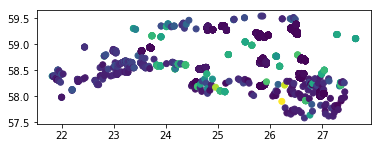

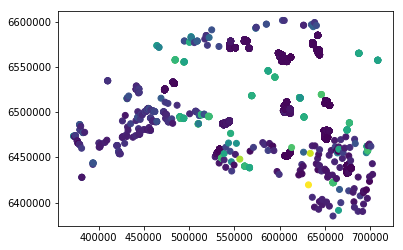

In [19]:
geo_soc.plot(column='SOC')
geo_soc_eest.plot(column='SOC')

geo_soc.to_file(driver='ESRI Shapefile', filename=os.path.join(soc_dir, "data/soc_rf_model/soc_consolidated_samples.shp"), encoding="utf-8")
geo_soc_eest.to_file(driver='ESRI Shapefile', filename=os.path.join(soc_dir, "data/soc_rf_model/soc_consolidated_samples_3301.shp"), encoding="utf-8")